# Publication-ready runs of protein mobility simulations

After solving the many-to-one binding issue by choosing the appropriate parameters, $r_{attr}=0.2$, $r_{rep}=1.2$, $E_{rep}=50k_B T$, bond wiggle distance = 0.01, we now analyze the full simulations with N=1000 particles.

In [1]:
%cd ..

/home/gridsan/dkannan/git-remotes/protein_mobility


In [6]:
from pathlib import Path
import numpy as np
import pandas as pd
import scipy as sp
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
#from tqdm.notebook import tqdm
import seaborn as sns
import sys
from numba import jit
sys.path.insert(0, '/home/gridsan/dkannan/git-remotes/polychrom_analysis/post_processing')
import msd

import polychrom
from polychrom.hdf5_format import list_URIs, load_URI, load_hdf5_file

slide_width = 11.5
half_slide_width = 5.67
aspect_ratio = 5/7
paper_params = {'axes.edgecolor': 'black',
                  'axes.facecolor':'white',
                  'axes.grid': False,
                  'axes.linewidth': 0.5,
                  'axes.spines.left' : True,
                  'axes.spines.right' : False,
                  'axes.spines.top' : False,
                  'axes.spines.bottom' : True,
                  'backend': 'ps',
                  'savefig.format': 'pdf',
                  'axes.titlesize': 10,
                  'axes.labelsize': 10,
                  'legend.fontsize': 10,
                  'xtick.labelsize': 8,
                  'ytick.labelsize': 8,
                  'text.usetex': False,
                  'figure.figsize': [3.0, 2.0],
                  'font.family': 'sans-serif',
                   'font.size': 10,
                  #'mathtext.fontset': 'cm',
                  'xtick.bottom':True,
                  'xtick.top': False,
                  'xtick.direction': 'out',
                  'xtick.major.pad': 3,
                  'xtick.major.size': 3,
                  'xtick.minor.bottom': False,
                  'xtick.major.width': 0.2,

                  'ytick.left':True,
                  'ytick.right':False,
                  'ytick.direction':'out',
                  'ytick.major.pad': 3,
                  'ytick.major.size': 3,
                  'ytick.major.width': 0.2,
                  'ytick.minor.right':False,
                  'lines.linewidth':2}

pres_params = {'axes.edgecolor': 'black',
                  'axes.facecolor':'white',
                  'axes.grid': False,
                  'axes.linewidth': 1.5,
                  'axes.spines.left' : True,
                  'axes.spines.right' : False,
                  'axes.spines.top' : False,
                  'axes.spines.bottom' : True,
                  'backend': 'ps',
                  'savefig.format': 'pdf',
                  'pdf.fonttype' : 42,
                  'ps.fonttype' : 42,
                  'axes.titlesize': 20,
                  'axes.labelsize': 18,
                  'legend.fontsize': 18,
                  'xtick.labelsize': 16,
                  'ytick.labelsize': 16,
                  'text.usetex': False,
                  'figure.figsize': [half_slide_width, half_slide_width * aspect_ratio],
                  'font.family': 'sans-serif',
                   'font.size': 14,
                  #'mathtext.fontset': 'cm',
                  'xtick.bottom':True,
                  'xtick.top': False,
                  'xtick.direction': 'out',
                  'xtick.major.pad': 4,
                  'xtick.major.size': 5,
                  'xtick.minor.bottom': False,
                  'xtick.major.width': 1.5,

                  'ytick.left':True,
                  'ytick.right':False,
                  'ytick.direction':'out',
                  'ytick.major.pad': 4,
                  'ytick.major.size': 5,
                  'ytick.major.width': 1.5,
                  'ytick.minor.right':False,
                  'lines.linewidth':2}
plt.rcParams.update(pres_params)

In [2]:
%matplotlib inline

In [3]:
simdir = Path('/home/gridsan/dkannan/git-remotes/protein_mobility/results')

In [5]:
def check_msd_equilibration(f, E0, r=0.2, repr=1.2, v=0.3, Erep=50.0, N=1000, dt=5, mixed=False, log=True):
    fig, ax = plt.subplots()
    if mixed:
        path = simdir/f"N{N}_f0_{f}_E0{E0}_v{v}_r{r}_rep{repr}_Erep{Erep}_dt{dt}"
    else:
        path = simdir/f"N{N}_f{f}_E0{E0}_v{v}_r{r}_rep{repr}_Erep{Erep}_dt{dt}"
    starts = [int(str(msdfile.name).split('_')[6][5:-4]) for msdfile in path.glob("time_ave_msd*.csv")]
    print(starts)
    starts = np.sort(starts)
    colors = sns.color_palette("viridis", len(starts))
    for i, start in enumerate(starts):
        msd_df = pd.read_csv(path/f'time_ave_msd_every_other_1_start{start:.0f}.csv')
        if mixed:
            ax.plot(msd_df['Time'].values[1:], msd_df[f'MSD_f{f}'].values[1:], label=f"start={start}", color=colors[i])
        else:
            ax.plot(msd_df['Time'].values[1:], msd_df['MSD'].values[1:], label=f"start={start}", color=colors[i])
    ax.set_xlabel("time")
    if log:
        ax.set_xscale("log")
        ax.set_yscale("log")
    ax.set_ylabel("MSD")
    # Put a legend to the right of the current axis
    ax.legend(loc=(1.04, 0.05))
    ax.set_title(f"N={N}, f={f}, r={r}, rep={repr}, Erep={Erep}, dt={dt}")
    
    

[2000, 1500, 1000, 500]


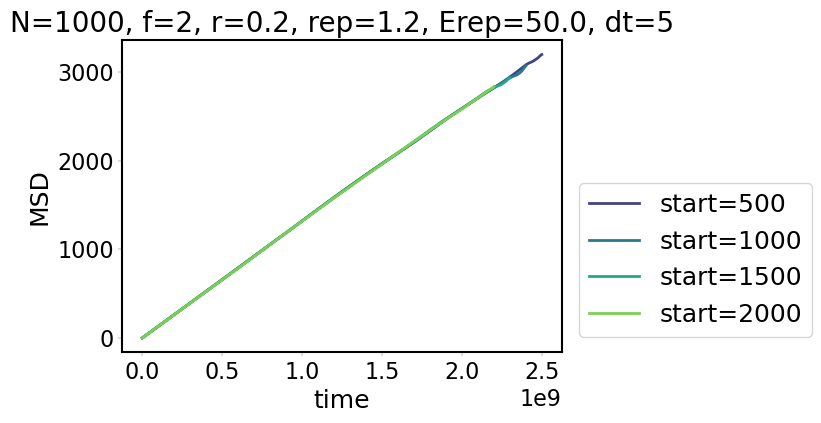

In [6]:
check_msd_equilibration(2, 20.0, mixed=True, log=False)

In [14]:
def plot_time_ave_msd_dt(f, r=0.2, repr=1.2, v=0.3, Erep=50.0, N=1000, dt=5, plot=True, mixed=False, start=500):
    if plot:
        fig, ax = plt.subplots()
    if mixed:
        E0s = [float(str(path.name).split('_')[3][2:]) for path in simdir.glob(f"N{N}_f0_2*_v{v}_r{r}_rep{repr}_Erep{Erep}_dt{dt}")]
    else:
        E0s = [float(str(path.name).split('_')[2][2:]) for path in simdir.glob(f"N{N}_f{f}*_v{v}_r{r}_rep{repr}_Erep{Erep}_dt{dt}")]
    #print(E0s)
    colors = sns.color_palette("viridis", len(E0s))
    Dapps = []
    alphas = []
    for i, E0 in enumerate(np.sort(E0s)):
        if mixed: 
            path = simdir/f"N{N}_f0_2_E0{E0}_v{v}_r{r}_rep{repr}_Erep{Erep}_dt{dt}"
            colname = f'MSD_f{f}'
        else:
            path = simdir/f"N{N}_f{f}_E0{E0}_v{v}_r{r}_rep{repr}_Erep{Erep}_dt{dt}"
            colname = 'MSD'
        msdfile = path/f'time_ave_msd_every_other_1_start{start}.csv'
        if msdfile.is_file():
            msd_df = pd.read_csv(path/f'time_ave_msd_every_other_1_start{start}.csv')
            #fit from delta t = 10 blocks to 1000 blocks
            if f==1 or f == 0:
                fit_range = (msd_df['Time'] >= 10**7) & (msd_df['Time'] <= 4e8)
            if f==2:
                fit_range = (msd_df['Time'] >= 0.5 * 10**8) & (msd_df['Time'] < 1.5 * 10**9)
            if plot and E0 > 11.0 and E0 < 22.0:
                ax.plot(msd_df['Time'].values[fit_range], msd_df[colname].values[fit_range], '-o',
                                label=f"$E_0={E0}$", color=colors[i])
            result = sp.stats.linregress(msd_df['Time'].values[fit_range], 
                                         msd_df[colname].values[fit_range])
            log_result = sp.stats.linregress(np.log10(msd_df['Time'].values[fit_range]), 
                                             np.log10(msd_df[colname].values[fit_range]))
            #print(f"Fit from linear space: {result.slope}t")
            #print(f"Fit from log space: {10**log_result.intercept}, alpha={log_result.slope}")
            Dapps.append(result.slope)
            alphas.append(log_result.slope)
    if plot:
        ax.set_xlabel("time")
        #ax.set_xscale("log")
        #ax.set_yscale("log")
        ax.set_ylabel("MSD")
        # Put a legend to the right of the current axis
        ax.legend(loc=(1.04, 0.05))
        if mixed: 
            ax.set_title(f"N={N/2}, f={f} subset, r={r}, rep={repr}, Erep={Erep}, dt={dt}")
        else:
            ax.set_title(f"N={N}, f={f}, r={r}, rep={repr}, Erep={Erep}, dt={dt}")
    return Dapps, alphas

[0.9894351673796461, 0.9955246253191908, 1.0015938737161616, 0.9957112432410645, 1.0135098902280104, 0.9977938315770652, 1.0068301375538977, 1.0031112464159206, 1.0031626388299084, 0.99573228288655, 1.0102927071623187, 1.0065490318188728, 0.9875136488127678, 0.9924633524610057, 0.9911517272628871, 1.003588815421012, 1.0238280515938707, 0.9973447951739416, 0.9992703056820225, 0.9884973298034647, 0.9939692362450202, 0.9816916335065347, 0.9959780450591154, 0.9894623271502322, 1.0008401129460556, 1.0099090665091253, 1.0038353871077104, 1.0102317399969574, 0.9681591654129625, 0.9833914903584838, 0.9844154938840157, 1.0092688180122884, 0.9820705806750619, 0.9951144439157343, 1.0047924320189794, 1.0054065005022335, 0.987841922971448, 1.0025649243386694, 0.9903771206884644, 1.0042355645022345, 0.9928465944135356, 1.0049922893284857, 0.9825738252659362, 0.9524907517419253, 0.9308439532314933, 0.871702268057955, 0.7881084504883125, 0.6775358801332196, 0.7008255575186249]


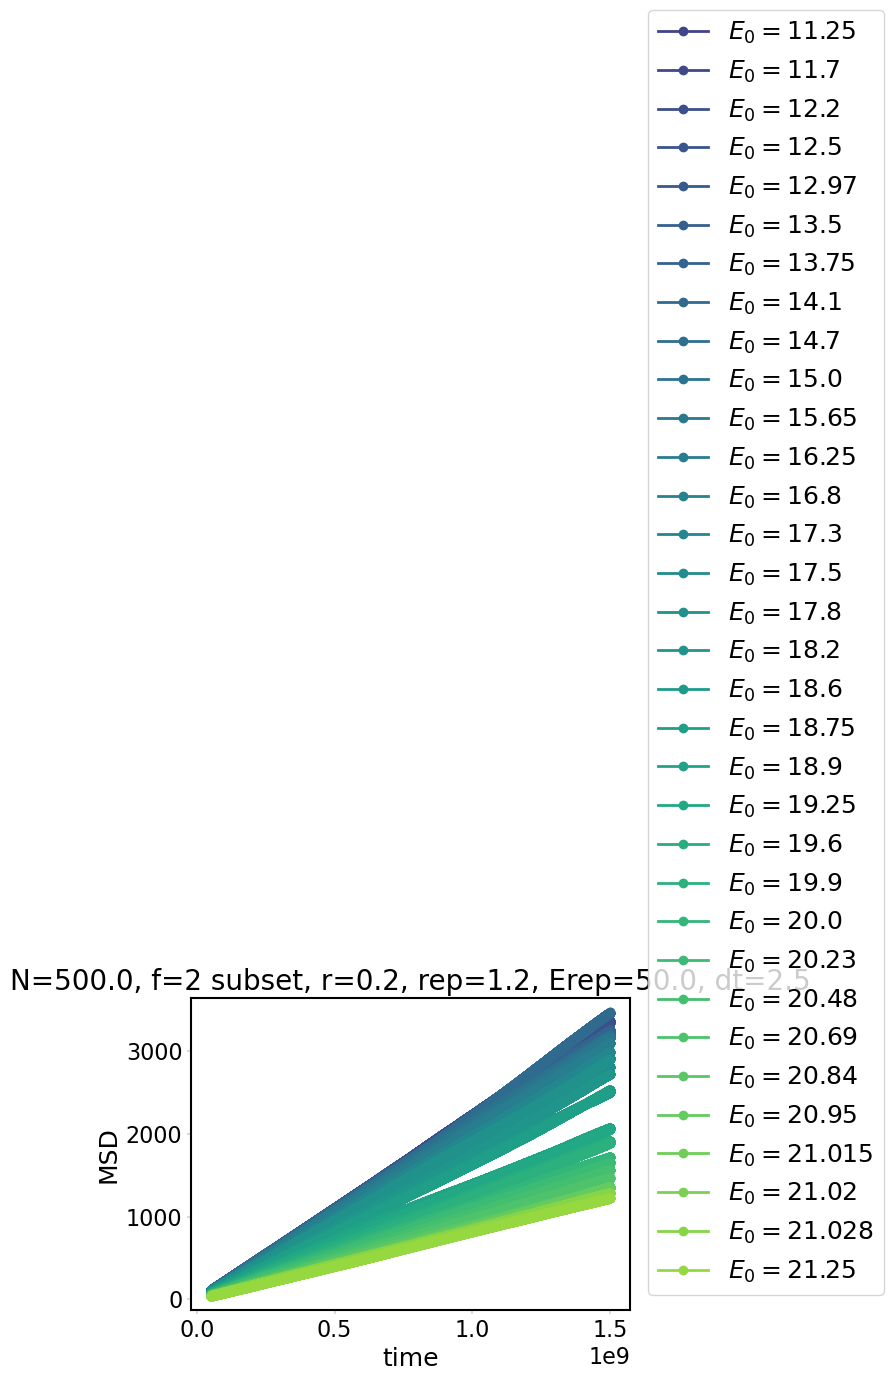

In [8]:
#simulation with half f=0 particles and half f=2 particles. MSD of just the f=2 particles
Dapps_f2_subset_dt5, alphas_f2_subset_dt5 = plot_time_ave_msd_dt(2, dt=5, mixed=True, plot=False)
Dapps_f2_subset_dt25, alphas_f2_subset_dt25 = plot_time_ave_msd_dt(2, dt=2.5, mixed=True, plot=True)
print(alphas_f2_subset_dt25)

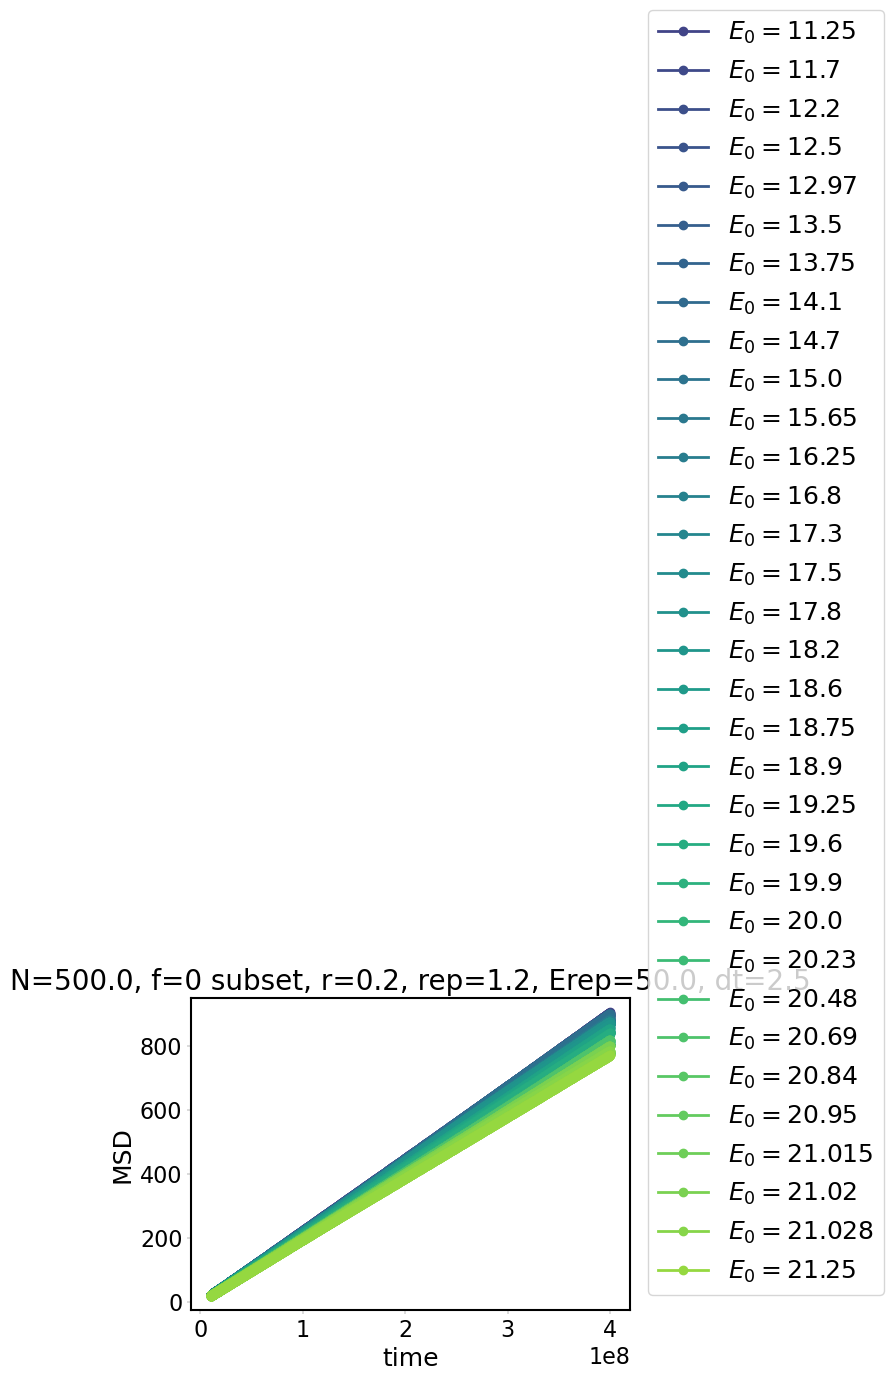

In [9]:
#simulation with half f=0 particles and half f=2 particles. MSD of just the f=2 particles
Dapps_f0_subset_dt5, alphas_f0_subset_dt5 = plot_time_ave_msd_dt(0, dt=5, mixed=True, plot=False)
Dapps_f0_subset_dt25, alphas_f0_subset_dt25 = plot_time_ave_msd_dt(0, dt=2.5, mixed=True, plot=True)

In [10]:
#combine dt=5 and dt=2.5 data
Dapps_f0_subset = []
Dapps_f2_subset = []
for i in range(len(Dapps_f0_subset_dt5)):
    Dapps_f0_subset.append(Dapps_f0_subset_dt5[i])
    Dapps_f0_subset.append(Dapps_f0_subset_dt25[i])
    Dapps_f2_subset.append(Dapps_f2_subset_dt5[i])
    Dapps_f2_subset.append(Dapps_f2_subset_dt25[i])


49
49
49


Text(0.5, 1.0, '50% f=2 particles, 50% f=0 particles')

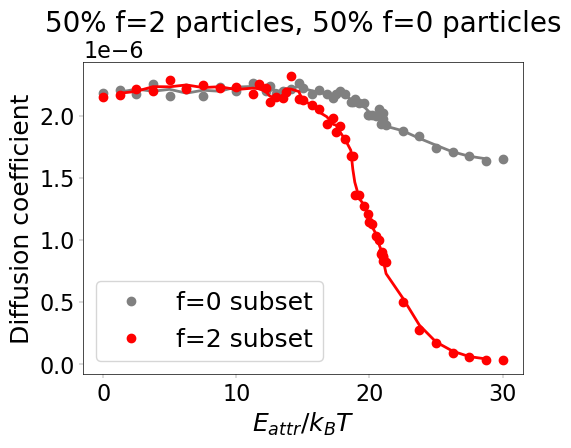

In [68]:
fig, ax = plt.subplots()
colors = ['black', 'red']
E0s = [float(str(path.name).split('_')[3][2:]) for path in simdir.glob(f"N1000_f0_2*_v0.3_r0.2_rep1.2_Erep50.0_dt2.5")]
E0s = np.sort(E0s)
print(len(E0s))
print(len(Dapps_f0_subset_dt25))
print(len(Dapps_f2_subset_dt25))
#Dapps_f0_subset_dt5 /= Dapps_f0_subset_dt5[0]
#Dapps_f0_subset_dt25 /= Dapps_f0_subset_dt25[0]
#Dapps_f2_subset_dt5 /= Dapps_f2_subset_dt5[0]
#Dapps_f2_subset_dt25 /= Dapps_f2_subset_dt25[0]
#ax.plot(E0s, Dapps_f0_subset_dt5, 'o', color='grey', label='f=0 subset')
ax.plot(E0s, Dapps_f0_subset_dt25, 'o', color='grey', label='f=0 subset')
#rolling average
window_size = 3
#Dapps_f0_roll_dt5 = np.convolve(Dapps_f0_subset_dt5, np.ones(window_size) / window_size, mode='valid')
Dapps_f0_roll_dt25 = np.convolve(Dapps_f0_subset_dt25, np.ones(window_size) / window_size, mode='valid')
ax.plot(E0s[1:-1], Dapps_f0_roll_dt25, '-', color='grey', label=None)
#Dapps_f2_roll_dt5 = np.convolve(Dapps_f2_subset_dt5, np.ones(window_size) / window_size, mode='valid')
Dapps_f2_roll_dt25 = np.convolve(Dapps_f2_subset_dt25, np.ones(window_size) / window_size, mode='valid')
#print(len(Dapps_f2_roll_dt5))
D_monomer = 1.0
meanD_vs_E0 = []
for E0 in E0s:
    histogram = np.load(simdir/f'N1000_f0_2_E0{E0}_v0.3_r0.2_rep1.2_Erep50.0_dt2.5/cluster_size_histogram.npy')
    weights = histogram / histogram.sum()
    num_clusters = (weights * 1000) / np.arange(1, len(weights) + 1)
    #diffusion coefficient distribution based on cluster sizes
    diffusion_clusters = (D_monomer / np.arange(1, len(weights) + 1))
    mean_diffusion = (diffusion_clusters @ num_clusters) / 1000
    meanD_vs_E0.append(mean_diffusion)
meanD_vs_E0 = np.array(meanD_vs_E0)
#ax.plot(E0s, Dapps_f2_subset_dt5, 'ro', label='f=2 subset')
ax.plot(E0s, Dapps_f2_subset_dt25, 'o', color='red', label='f=2 subset')
ax.plot(E0s[1:-1], Dapps_f2_roll_dt25, '-', color='red', label=None)
#ax.plot(E0s, (meanD_vs_E0 / meanD_vs_E0[0])*Dapps_f2_subset_dt25[0], 'r--', label=None)
ax.legend()
ax.set_xlabel('$E_{attr} / k_B T$')
ax.set_ylabel('Diffusion coefficient')
ax.set_title("50% f=2 particles, 50% f=0 particles")
#ax.set_title("Predicted (--) vs Measured(-)")

9
[ 0.3918244   1.24508652 22.23118309  0.72070372]
[8.36103333e-01 4.74451713e-01 1.88266438e+01 3.66751204e-22]


Text(0, 0.5, 'Diffusion coefficient')

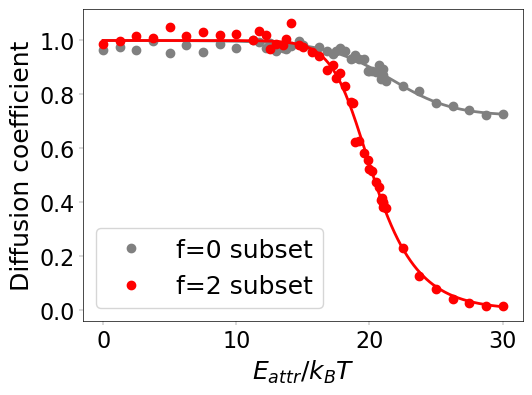

In [109]:
#Curve fitting
def fermi_func_inc(x, k, a, xmean):
    return np.power(1./(1. + np.exp(-k*(x - xmean))), a)

def fermi_func_dec(x, k, a, xmean, min):
    return min + (1.0 - min)*np.power(np.exp(-k*(x - xmean))/(1. + np.exp(-k*(x - xmean))), a)

fig, ax = plt.subplots()
Evals = np.linspace(0.0, 30.0, 500)
zeroind = np.where(E0s == 11.25)[0][0]
print(zeroind)
Dapps_f0_subset_dt25_norm = Dapps_f0_subset_dt25 / Dapps_f0_subset_dt25[zeroind]
popt_f0, pcov_f0 = sp.optimize.curve_fit(fermi_func_dec, E0s[E0s >= 11.25], Dapps_f0_subset_dt25_norm[E0s >= 11.25], [1.0, 1.0, 20.0, 0.7], bounds=([0.0, 0.0, 10.0, 0.0], [np.inf, np.inf, 30.0, 1.0]))
print(popt_f0)
ax.plot(E0s, Dapps_f0_subset_dt25_norm, 'o', color='gray', label='f=0 subset')
ax.plot(Evals, fermi_func_dec(Evals, k=popt_f0[0], a=popt_f0[1], xmean=popt_f0[2], min=popt_f0[3]), '-', color='grey', label=None)
Dapps_f2_subset_dt25_norm = Dapps_f2_subset_dt25 / Dapps_f2_subset_dt25[zeroind]
popt_f2, pcov_f2 = sp.optimize.curve_fit(fermi_func_dec, E0s[E0s >= 11.25], Dapps_f2_subset_dt25_norm[E0s >= 11.25], [1.0, 1.0, 20.0, 0.0], bounds=([0.0, 0.0, 10.0, 0.0], [np.inf, np.inf, 30.0, 1.0]))
print(popt_f2)
ax.plot(E0s, Dapps_f2_subset_dt25_norm, 'o', color='red', label='f=2 subset')
ax.plot(Evals, fermi_func_dec(Evals, k=popt_f2[0], a=popt_f2[1], xmean=popt_f2[2], min=popt_f2[3]), 'r-', label=None)
ax.set_xlabel('$E_{attr} / k_B T$')
ax.legend()
ax.set_ylabel('Diffusion coefficient')


[1.0e+00 6.0e-02 2.2e+01 1.7e-06 2.2e-06]
[1.0e+000 4.0e-001 2.2e+001 4.9e-324 2.2e-006]


Text(0, 0.5, 'Diffusion coefficient')

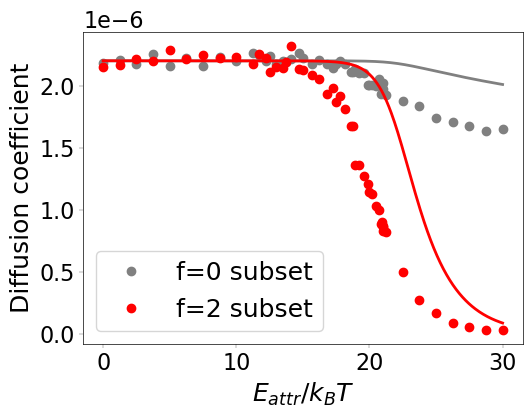

In [92]:
def fermi_func_dec_max(x, k, a, xmean, min, max):
    return min + (max - min)*np.power(np.exp(-k*(x - xmean))/(1. + np.exp(-k*(x - xmean))), a)

fig, ax = plt.subplots()
Evals = np.linspace(0.0, 30.0, 500)
popt_f0, pcov_f0 = sp.optimize.curve_fit(fermi_func_dec_max, E0s, Dapps_f0_subset_dt25, [1.0, 0.06, 22.0, 1.7e-6, 2.2e-6], 
                                         bounds=([0.0, 0.0, 10.0, 0.0, 0.0], [np.inf, np.inf, 30.0, 3.0e-6, 3.0e-6]))
print(popt_f0)
ax.plot(E0s, Dapps_f0_subset_dt25, 'o', color='gray', label='f=0 subset')
ax.plot(Evals, fermi_func_dec_max(Evals, k=popt_f0[0], a=popt_f0[1], xmean=popt_f0[2], min=popt_f0[3], max=popt_f0[4]), '-', color='grey', label=None)
popt_f2, pcov_f2 = sp.optimize.curve_fit(fermi_func_dec_max, E0s, Dapps_f2_subset_dt25, [1.0, 0.4, 22.0, 0.0, 2.2e-6], 
                                         bounds=([0.0, 0.0, 10.0, 0.0, 0.0], [np.inf, np.inf, 30.0, 3.0e-6, 3.0e-6]))
print(popt_f2)
ax.plot(E0s, Dapps_f2_subset_dt25, 'o', color='red', label='f=2 subset')
ax.plot(Evals, fermi_func_dec_max(Evals, k=popt_f2[0], a=popt_f2[1], xmean=popt_f2[2], min=popt_f2[3], max=popt_f2[4]), 'r-', label=None)
ax.set_xlabel('$E_{attr} / k_B T$')
ax.legend()
ax.set_ylabel('Diffusion coefficient')

In [27]:
#Plot cluster size distribution
def plot_cluster_size_distribution(E0, f=1, N=1000, v=0.3, r=0.2, rep=1.2, Erep=50.0, dt=5, mixed=False):
    if mixed:
        sim = simdir/f'N{N}_f0_2_E0{E0}_v{v}_r{r}_rep{rep}_Erep{Erep}_dt{dt}'
    else:
        sim = simdir/f'N{N}_f{f}_E0{E0}_v{v}_r{r}_rep{rep}_Erep{Erep}_dt{dt}'
    histogram = np.load(sim/'cluster_size_histogram.npy')
    weights = histogram[histogram > 0] / histogram[histogram > 0].sum()
    num_clusters = (weights * 1000) / np.arange(1, len(weights) + 1)
    cdf = np.cumsum(weights)
    fig, ax = plt.subplots()
    ax.bar(np.arange(1, len(weights) + 1), weights, width=1.0)
    ax.set_xlabel('m')
    ax.set_ylabel('Fraction in multimer m')
    if mixed:
        ax.set_title(f"f={f} susbset (N=500), $E_{{attr}}=${E0}$k_B T$")
    else:
        ax.set_title(f"All f={f} (N=1000), $E_{{attr}}=${E0}$k_B T$")
    fig.tight_layout()
    plt.savefig(f'plots/SF_cluster_size_distribution_E0{E0}_f{f}.pdf')
    #ax.set_title(f"f={f}, $r_{{rep}}$={rep}, $r_{{attr}}$={r}, $E_0$={E0}, $Erep={Erep}$, $dt={dt}$")


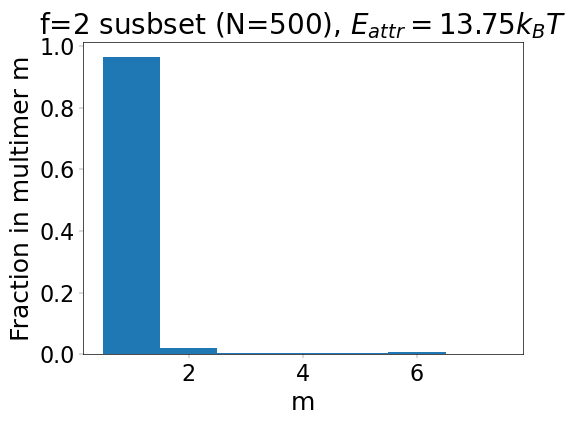

In [130]:
plot_cluster_size_distribution(13.75, 2, dt=2.5, mixed=True)

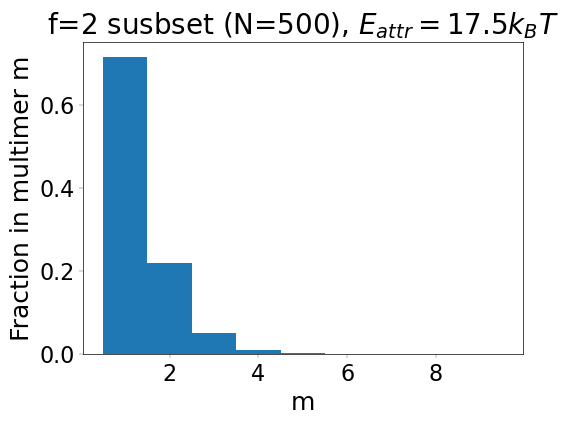

In [131]:
plot_cluster_size_distribution(17.5, 2, dt=2.5, mixed=True)

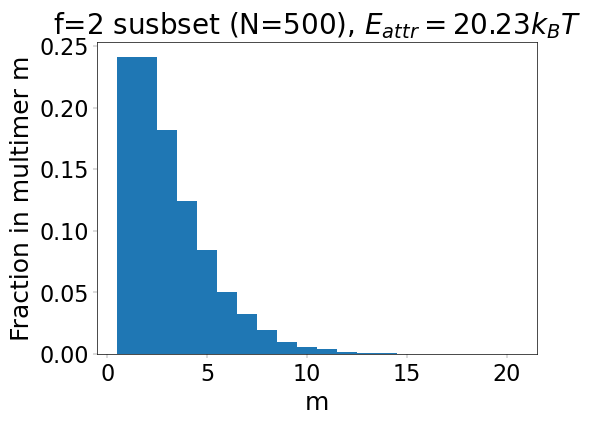

In [132]:
plot_cluster_size_distribution(20.23, 2, dt=2.5, mixed=True)

In [110]:
old_df = pd.read_csv(simdir/"multimer_stats_N1000_f0_2_v0.3_rep1.2_rattr0.2_Erep50_dt5_dt2.5_varying_E0.csv")
old_df.sort_values('E0', inplace=True)
df_dt25 = old_df[old_df['dt'] == 2.5]
df_dt5 = old_df[old_df['dt'] == 5]
df_dt5['Dapp_f2'] = Dapps_f2_subset_dt5
df_dt5['Dapp_f0'] = Dapps_f0_subset_dt5

/tmp/ipykernel_2561888/3206996447.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dt5['Dapp_f2'] = Dapps_f2_subset_dt5
/tmp/ipykernel_2561888/3206996447.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dt5['Dapp_f0'] = Dapps_f0_subset_dt5


In [111]:
df = pd.read_csv(simdir/"multimer_stats_N1000_f0_2_v0.3_rep1.2_rattr0.2_Erep50_dt2.5_varying_E0.csv")
df_dt25 = pd.concat([df_dt25, df], ignore_index=True)
df_dt25.sort_values('E0', inplace=True)
print(df_dt25.shape)
df_dt25['Dapp_f2'] = Dapps_f2_subset_dt25
df_dt25['D2_fermi'] = fermi_func_dec(df_dt25['E0'], k=popt_f2[0], a=popt_f2[1], xmean=popt_f2[2], min=popt_f2[3])
df_dt25['Dapp_f0'] = Dapps_f0_subset_dt25
df_dt25['D0_fermi'] = fermi_func_dec(df_dt25['E0'], k=popt_f0[0], a=popt_f0[1], xmean=popt_f0[2], min=popt_f0[3])
df_dt25

(49, 12)


,N,f,E0,v,r,rep_r,Erep,dt,fraction_bonded,fraction_many_to_one,fraction_multimer,fraction_3plusmer,Dapp_f2,D2_fermi,Dapp_f0,D0_fermi
0,1000,2,0.000,0.3,0.2,1.2,50.0,2.5,0.000009,NaN,0.000018,0.000000,2.152956e-06,1.000000,0.000002,0.999943
1,1000,2,1.250,0.3,0.2,1.2,50.0,2.5,0.000012,NaN,0.000024,0.000000,2.170059e-06,1.000000,0.000002,0.999906
2,1000,2,2.500,0.3,0.2,1.2,50.0,2.5,0.000016,NaN,0.000031,0.000000,2.216043e-06,0.999999,0.000002,0.999847
3,1000,2,3.750,0.3,0.2,1.2,50.0,2.5,0.000028,NaN,0.000056,0.000000,2.201080e-06,0.999998,0.000002,0.999751
4,1000,2,5.000,0.3,0.2,1.2,50.0,2.5,0.000035,NaN,0.000070,0.000000,2.282853e-06,0.999995,0.000002,0.999594
5,1000,2,6.250,0.3,0.2,1.2,50.0,2.5,0.000061,NaN,0.000121,0.000000,2.212713e-06,0.999987,0.000002,0.999338
6,1000,2,7.500,0.3,0.2,1.2,50.0,2.5,0.000110,NaN,0.000220,0.000000,2.245733e-06,0.999963,0.000002,0.998921
7,1000,2,8.750,0.3,0.2,1.2,50.0,2.5,0.000250,NaN,0.000500,0.000000,2.219776e-06,0.999896,0.000002,0.998243
8,1000,2,10.000,0.3,0.2,1.2,50.0,2.5,0.000555,NaN,0.001110,0.000000,2.232569e-06,0.999704,0.000002,0.997143
9,1000,2,11.250,0.3,0.2,1.2,50.0,2.5,0.001443,NaN,0.002884,0.002714,2.177723e-06,0.999160,0.000002,0.995365


[ 0.48933407  1.81561875 18.55772962]


Text(0, 0.5, 'Fraction bonded cysteines')

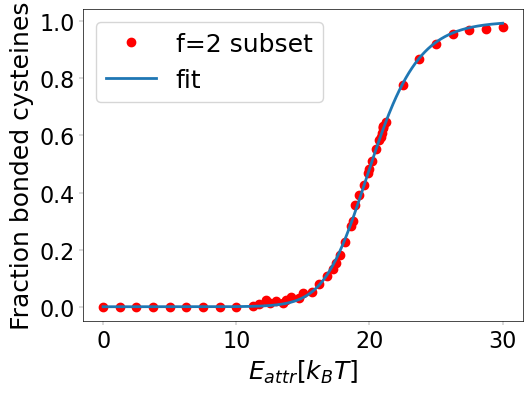

In [112]:
fig, ax = plt.subplots()
styles = ['-o', '-^']
i = 0
ax.plot(df_dt25["E0"], df_dt25["fraction_bonded"], 'o', color='red', label=f'f=2 subset')
popt_frac_bound, pcov_frac_bound = sp.optimize.curve_fit(fermi_func_inc, df_dt25["E0"], df_dt25["fraction_bonded"], 
                                                         [1.0, 1.0, 20.0], bounds=([0.0, 0.0, 10.0], [np.inf, np.inf, 30.0]))
print(popt_frac_bound)
ax.plot(Evals, fermi_func_inc(Evals, k=popt_frac_bound[0], a=popt_frac_bound[1], xmean=popt_frac_bound[2]), '-', label='fit')
ax.legend()
ax.set_xlabel(r"$E_{attr} [k_B T]$")
ax.set_ylabel("Fraction bonded cysteines")

In [113]:
# Plot against Ming's data
data_df = pd.read_csv("data/redox_vs_SS.csv")
data_df

,H2O2(uM),GSSG:GSH,frac-PSSG,frac-PSSP*2,frac-PSSP*2+PSSG
0,0.001000,0.001000,0.001015,0.002045,0.003059
1,0.001122,0.001123,0.001138,0.002293,0.003431
2,0.001259,0.001260,0.001276,0.002572,0.003848
3,0.001413,0.001413,0.001431,0.002885,0.004316
4,0.001585,0.001586,0.001605,0.003235,0.004840
...,...,...,...,...,...
96,63.095734,28.392764,0.481337,0.515154,0.996491
97,70.794578,30.529155,0.494441,0.502494,0.996935
98,79.432823,32.820992,0.508172,0.489145,0.997317
99,89.125094,35.280588,0.522503,0.475139,0.997643


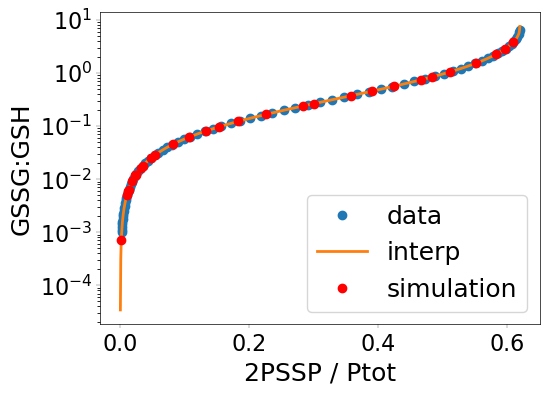

In [114]:
from scipy.interpolate import CubicSpline

fig, ax = plt.subplots()

ax.plot(data_df['frac-PSSP*2'][0:79], data_df['GSSG:GSH'][0:79], 'o', label='data')
cs = CubicSpline(data_df['frac-PSSP*2'][0:79], data_df['GSSG:GSH'][0:79])
xvals = np.linspace(0.0, 0.62, 1000)
ax.plot(xvals, cs(xvals), label='interp')
plot_range = (df_dt25['E0'] >= 11.25) & (df_dt25['fraction_bonded'] <= 0.62)
ax.plot(df_dt25['fraction_bonded'][plot_range], cs(df_dt25['fraction_bonded'][plot_range]), 'ro', label='simulation')
#ax.plot(df_dt5['fraction_bonded'], cs(df_dt5['fraction_bonded']), 'ro', label='dt=5')
ax.set_yscale("log")
#ax.set_xscale('log')
ax.set_xlabel("2PSSP / Ptot")#
ax.set_ylabel("GSSG:GSH")
ax.legend()

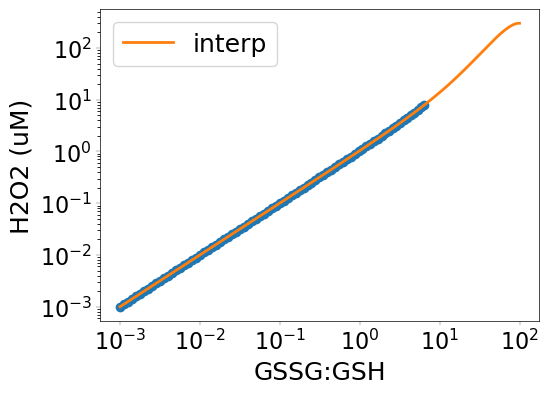

In [115]:
fig, ax = plt.subplots()
ax.plot(data_df['GSSG:GSH'][0:79], data_df['H2O2(uM)'][0:79], 'o')
cs2 = CubicSpline(data_df['GSSG:GSH'], data_df['H2O2(uM)'])
GSSGvals = np.logspace(-3, 2, 1000)
ax.plot(GSSGvals, cs2(GSSGvals), label='interp')
ax.set_xlabel("GSSG:GSH")
ax.set_ylabel("H2O2 (uM)")
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()

In [118]:
df_dt25['fraction_bonded_fermi'] = fermi_func_inc(df_dt25['E0'], k=popt_frac_bound[0], a=popt_frac_bound[1], xmean=popt_frac_bound[2])
df_dt25['GSSG:GSH'] = cs(df_dt25['fraction_bonded'])
df_dt25['GSSG:GSH_fermi'] = cs(df_dt25['fraction_bonded_fermi'])
df_dt25['H2O2'] = cs2(df_dt25['GSSG:GSH'])
df_dt25['H2O2_fermi'] = cs2(df_dt25['GSSG:GSH_fermi'])
df_dt5['GSSG:GSH'] = cs(df_dt5['fraction_bonded'])
df_dt5['H2O2'] = cs2(df_dt5['GSSG:GSH'])
df_dt25

/tmp/ipykernel_2561888/2730603461.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dt5['GSSG:GSH'] = cs(df_dt5['fraction_bonded'])
/tmp/ipykernel_2561888/2730603461.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dt5['H2O2'] = cs2(df_dt5['GSSG:GSH'])


,N,f,E0,v,r,rep_r,Erep,dt,fraction_bonded,fraction_many_to_one,...,fraction_3plusmer,Dapp_f2,D2_fermi,Dapp_f0,D0_fermi,fraction_bonded_fermi,GSSG:GSH,H2O2,GSSG:GSH_fermi,H2O2_fermi
0,1000,2,0.000,0.3,0.2,1.2,50.0,2.5,0.000009,NaN,...,0.000000,2.152956e-06,1.000000,0.000002,0.999943,6.909993e-08,3.832277e-05,4.514451e-05,3.441880e-05,4.131569e-05
1,1000,2,1.250,0.3,0.2,1.2,50.0,2.5,0.000012,NaN,...,0.000000,2.170059e-06,1.000000,0.000002,0.999906,2.097538e-07,3.971220e-05,4.650731e-05,3.448117e-05,4.137685e-05
2,1000,2,2.500,0.3,0.2,1.2,50.0,2.5,0.000016,NaN,...,0.000000,2.216043e-06,0.999999,0.000002,0.999847,6.366171e-07,4.133368e-05,4.809781e-05,3.467045e-05,4.156247e-05
3,1000,2,3.750,0.3,0.2,1.2,50.0,2.5,0.000028,NaN,...,0.000000,2.201080e-06,0.999998,0.000002,0.999751,1.931653e-06,4.689702e-05,5.355552e-05,3.524472e-05,4.212567e-05
4,1000,2,5.000,0.3,0.2,1.2,50.0,2.5,0.000035,NaN,...,0.000000,2.282853e-06,0.999995,0.000002,0.999594,5.858188e-06,4.991306e-05,5.651472e-05,3.698633e-05,4.383373e-05
5,1000,2,6.250,0.3,0.2,1.2,50.0,2.5,0.000061,NaN,...,0.000000,2.212713e-06,0.999987,0.000002,0.999338,1.775001e-05,6.129727e-05,6.768715e-05,4.226462e-05,4.901100e-05
6,1000,2,7.500,0.3,0.2,1.2,50.0,2.5,0.000110,NaN,...,0.000000,2.245733e-06,0.999963,0.000002,0.998921,5.369085e-05,8.344023e-05,8.943045e-05,5.825091e-05,6.469704e-05
7,1000,2,8.750,0.3,0.2,1.2,50.0,2.5,0.000250,NaN,...,0.000000,2.219776e-06,0.999896,0.000002,0.998243,1.619033e-04,1.464000e-04,1.513398e-04,1.066816e-04,1.122695e-04
8,1000,2,10.000,0.3,0.2,1.2,50.0,2.5,0.000555,NaN,...,0.000000,2.232569e-06,0.999704,0.000002,0.997143,4.854552e-04,2.861792e-04,2.892091e-04,2.539838e-04,2.574050e-04
9,1000,2,11.250,0.3,0.2,1.2,50.0,2.5,0.001443,NaN,...,0.002714,2.177723e-06,0.999160,0.000002,0.995365,1.440695e-03,7.073495e-04,7.073973e-04,7.061113e-04,7.061632e-04


Text(0.5, 0, 'fraction bonded cysteines')

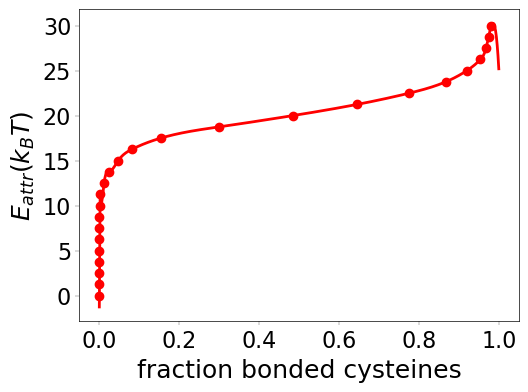

In [23]:
fig, ax = plt.subplots()
ax.plot(df_dt25['fraction_bonded'], df_dt25['E0'], 'ro')
Evals = np.linspace(0.0, 30.0, 500)
fraction_vals = np.linspace(0.0, 1.0, 500)
#fit fermi function
popt, pcov = sp.optimize.curve_fit(fermi_func_inc, df_dt25['E0'], df_dt25['fraction_bonded'], [1.0, 1.0, 20.0], bounds=([0.0, 0.0, 10.0], [np.inf, np.inf, 30.0]))
#or just do cubic interpolation
cs_SS_Eattr = CubicSpline(df_dt25['fraction_bonded'], df_dt25['E0'])
ax.plot(fraction_vals, cs_SS_Eattr(fraction_vals), 'r-')
#ax.plot(Evals, fermi_func_inc(Evals, k=popt[0], a=popt[1], xmean=popt[2]), '-', color='red', label=None)
ax.set_ylabel(r'$E_{attr} (k_B T)$')
ax.set_xlabel('fraction bonded cysteines')
#ax.set_xscale('log')
#ax.set_yscale('log')

[10.89317164 10.56423492 10.31418496 10.28941393 10.69969471 11.70706688
 12.97252006 13.66548727 13.76153102 14.1038154  14.89446127 15.69195621
 16.25447018 16.77360512 17.2953084  17.78141156 18.20399705 18.56401335
 18.90540251 19.25862073 19.60815361 19.9363108  20.22925066 20.47996043
 20.6850321  20.84298567 20.95346699 21.01570074 21.02734959 21.0203139 ]
[10.8926655  10.53712372 10.28811186 10.3461082  10.9845351  12.28903498
 13.43123405 13.74607059 13.94910117 14.70223259 15.60437594 16.23346057
 16.7966321  17.36027939 17.87660805 18.31482018 18.69006633 19.06339302
 19.44271024 19.80507212 20.13084601 20.40876163 20.63461908 20.80755196
 20.92915609 21.0021324  21.0288497 ]


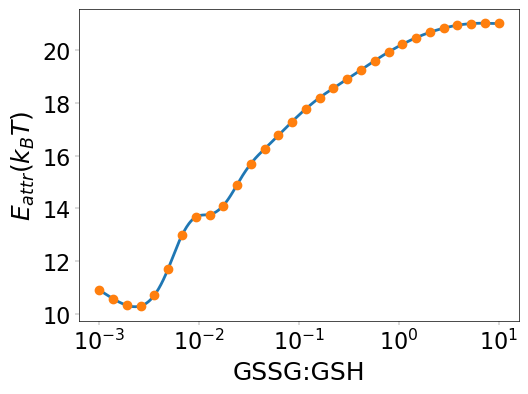

In [29]:
data_df['Eattr'] = cs_SS_Eattr(data_df['frac-PSSP*2'])
fig, ax = plt.subplots()
#ax.plot(data_df['GSSG:GSH'][0:79], data_df['Eattr'][0:79], 'o')
#interpolate Eattr vs GSSG:GSH
cs_Eattr_GSSG = CubicSpline(data_df['GSSG:GSH'][0:79], data_df['Eattr'][0:79])
ratio_vals = np.logspace(-3, 1, 500)
ax.plot(ratio_vals, cs_Eattr_GSSG(ratio_vals), '-')
ratio_vals = np.logspace(-3, 1, 30)
ax.plot(ratio_vals, cs_Eattr_GSSG(ratio_vals), 'o')
print(cs_Eattr_GSSG(ratio_vals))
#then log space the ratio values and determine which Eattr values to run accordingly
ax.set_xlabel('GSSG:GSH')
ax.set_ylabel(r'$E_{attr} (k_B T)$')
ax.set_xscale('log')
print(data_df['Eattr'][0:79].values[::3])

2.260918780611967e-06
2.177722900284171e-06
       N  f     E0    v    r  rep_r  Erep   dt  fraction_bonded  \
9   1000  2  11.25  0.3  0.2    1.2  50.0  2.5         0.001443   
25  1000  2  11.70  0.3  0.2    1.2  50.0  2.5         0.010138   
26  1000  2  12.20  0.3  0.2    1.2  50.0  2.5         0.023414   
10  1000  2  12.50  0.3  0.2    1.2  50.0  2.5         0.011918   
27  1000  2  12.97  0.3  0.2    1.2  50.0  2.5         0.018405   
28  1000  2  13.50  0.3  0.2    1.2  50.0  2.5         0.012647   
11  1000  2  13.75  0.3  0.2    1.2  50.0  2.5         0.023854   
29  1000  2  14.10  0.3  0.2    1.2  50.0  2.5         0.034417   
30  1000  2  14.70  0.3  0.2    1.2  50.0  2.5         0.031471   
12  1000  2  15.00  0.3  0.2    1.2  50.0  2.5         0.047379   
31  1000  2  15.65  0.3  0.2    1.2  50.0  2.5         0.053206   
13  1000  2  16.25  0.3  0.2    1.2  50.0  2.5         0.081263   
32  1000  2  16.80  0.3  0.2    1.2  50.0  2.5         0.106901   
33  1000  2  17.30

Text(0.5, 1.0, '50% f=2 particles, 50% f=0 particles')

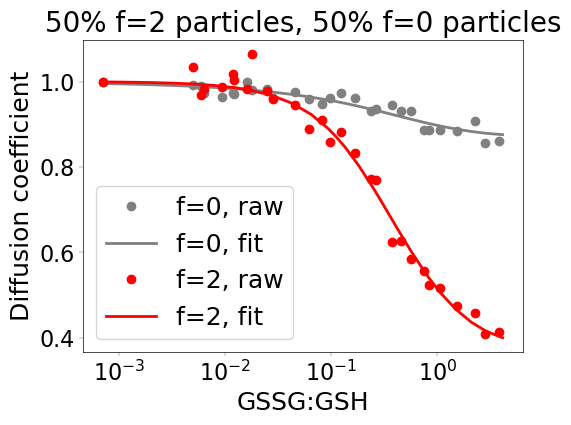

In [124]:
fig, ax = plt.subplots()
plot_range = (df_dt25['E0'] >= 11.25) & (df_dt25['fraction_bonded'] <= 0.62)
D0 = df_dt25['Dapp_f0'][plot_range].values[0]
print(D0)
D2 = df_dt25['Dapp_f2'][plot_range].values[0]
print(D2)
ax.plot(df_dt25['GSSG:GSH'][plot_range], df_dt25['Dapp_f0'][plot_range]/D0, 'o', color='grey', label='f=0, raw')
ax.plot(df_dt25['GSSG:GSH_fermi'][plot_range], df_dt25['D0_fermi'][plot_range], '-', color='grey', label='f=0, fit')
ax.plot(df_dt25['GSSG:GSH'][plot_range], df_dt25['Dapp_f2'][plot_range]/D2, 'ro', label='f=2, raw')
print(df_dt25[plot_range])
ax.plot(df_dt25['GSSG:GSH_fermi'][plot_range], df_dt25['D2_fermi'][plot_range], 'r-', label='f=2, fit')
#ax.plot(df_dt5['GSSG:GSH'], df_dt5['Dapp_f0'], 'o', color='grey', label='f=0 subset')
#ax.plot(df_dt5['GSSG:GSH'], df_dt5['Dapp_f2'], 'ro', label='f=2 subset')
#ax.plot(E0s, (meanD_vs_E0 / meanD_vs_E0[0])*Dapps_f2_subset[0], 'r--', label=None)
ax.legend()
ax.set_xscale('log')
ax.set_xlabel('GSSG:GSH')
ax.set_ylabel('Diffusion coefficient')
ax.set_title("50% f=2 particles, 50% f=0 particles")


In [125]:
df_dt25[plot_range]

,N,f,E0,v,r,rep_r,Erep,dt,fraction_bonded,fraction_many_to_one,...,fraction_3plusmer,Dapp_f2,D2_fermi,Dapp_f0,D0_fermi,fraction_bonded_fermi,GSSG:GSH,H2O2,GSSG:GSH_fermi,H2O2_fermi
9,1000,2,11.25,0.3,0.2,1.2,50.0,2.5,0.001443,NaN,...,0.002714,2.177723e-06,0.999160,0.000002,0.995365,0.001441,0.000707,0.000707,0.000706,0.000706
25,1000,2,11.70,0.3,0.2,1.2,50.0,2.5,0.010138,0.384439,...,0.584172,2.254223e-06,0.998777,0.000002,0.994487,0.002123,0.005021,0.005020,0.001039,0.001038
26,1000,2,12.20,0.3,0.2,1.2,50.0,2.5,0.023414,0.375031,...,0.498012,2.218741e-06,0.998143,0.000002,0.993319,0.003255,0.011833,0.011833,0.001595,0.001595
10,1000,2,12.50,0.3,0.2,1.2,50.0,2.5,0.011918,0.306588,...,0.394617,2.111608e-06,0.997616,0.000002,0.992506,0.004197,0.005919,0.005917,0.002060,0.002059
27,1000,2,12.97,0.3,0.2,1.2,50.0,2.5,0.018405,0.260012,...,0.334663,2.148717e-06,0.996475,0.000002,0.991035,0.006228,0.009230,0.009229,0.003067,0.003066
28,1000,2,13.50,0.3,0.2,1.2,50.0,2.5,0.012647,0.201241,...,0.200732,2.140946e-06,0.994526,0.000002,0.989039,0.009655,0.006287,0.006286,0.004779,0.004777
11,1000,2,13.75,0.3,0.2,1.2,50.0,2.5,0.023854,0.479879,...,0.446589,2.187134e-06,0.993267,0.000002,0.987955,0.011839,0.012064,0.012063,0.005879,0.005877
29,1000,2,14.10,0.3,0.2,1.2,50.0,2.5,0.034417,0.489961,...,0.498213,2.317116e-06,0.991010,0.000002,0.986264,0.015691,0.017693,0.017697,0.007837,0.007836
30,1000,2,14.70,0.3,0.2,1.2,50.0,2.5,0.031471,0.349317,...,0.300131,2.137347e-06,0.985286,0.000002,0.982826,0.025138,0.016104,0.016107,0.012738,0.012739
12,1000,2,15.00,0.3,0.2,1.2,50.0,2.5,0.047379,0.467422,...,0.415713,2.127311e-06,0.981213,0.000002,0.980817,0.031613,0.024861,0.024873,0.016181,0.016183


Text(0.5, 1.0, '50% f=2 particles, 50% f=0 particles')

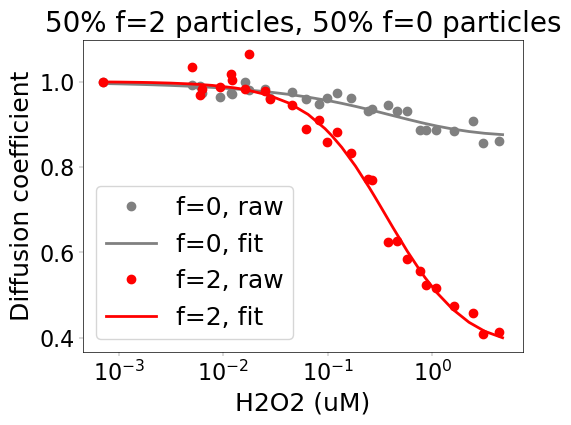

In [120]:
fig, ax = plt.subplots()
ax.plot(df_dt25['H2O2'][plot_range], df_dt25['Dapp_f0'][plot_range]/D0, 'o', color='grey', label='f=0, raw')
ax.plot(df_dt25['H2O2_fermi'][plot_range], df_dt25['D0_fermi'][plot_range], '-', color='grey', label='f=0, fit')
ax.plot(df_dt25['H2O2'][plot_range], df_dt25['Dapp_f2'][plot_range]/D2, 'ro', label='f=2, raw')
ax.plot(df_dt25['H2O2_fermi'][plot_range], df_dt25['D2_fermi'][plot_range], 'r-', label='f=2, fit')
#ax.plot(df_dt5['GSSG:GSH'], df_dt5['Dapp_f0'], 'o-', color='grey', label='f=0 subset')
#ax.plot(df_dt5['GSSG:GSH'], df_dt5['Dapp_f2'], 'ro-', label='f=2 subset')
#ax.plot(E0s, (meanD_vs_E0 / meanD_vs_E0[0])*Dapps_f2_subset[0], 'r--', label=None)
ax.legend()
ax.set_xscale('log')
ax.set_xlabel('H2O2 (uM)')
ax.set_ylabel('Diffusion coefficient')
ax.set_title("50% f=2 particles, 50% f=0 particles")

# Homogeneous population simulations with all f=1 or f=2

f=1 is useful for SI figure showing hyperparameter validation, but not much else. NOTE: cluster size distribution calculations need to be run for the pure f=1 and f=2 simulations (did not re-run after bug was caught)

In [4]:
df_f12 = pd.read_csv(simdir/"multimer_stats_N1000_f1_2_v0.3_rep1.2_rattr0.2_Erep50_dt5_varying_E0.csv")

Text(0, 0.5, 'Fraction bonded cysteines')

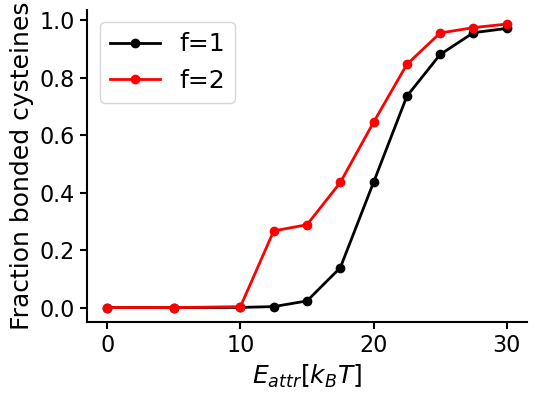

In [7]:
fig, ax = plt.subplots()
colors = ["black", "red"]
for f, mat in df_f12.groupby("f"):
    ax.plot(mat["E0"], mat["fraction_bonded"], '-o', color=colors[f-1], label=f'f={f}')
    #ax.plot(mat["E0"], mat["fraction_multimer"], '--', color=colors[f-1], label=f'f={f}')
ax.legend()
ax.set_xlabel(r"$E_{attr} [k_B T]$")
ax.set_ylabel("Fraction bonded cysteines")

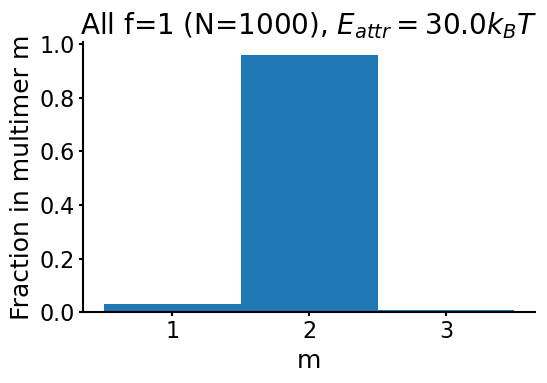

In [28]:
plot_cluster_size_distribution(30.0, 1)

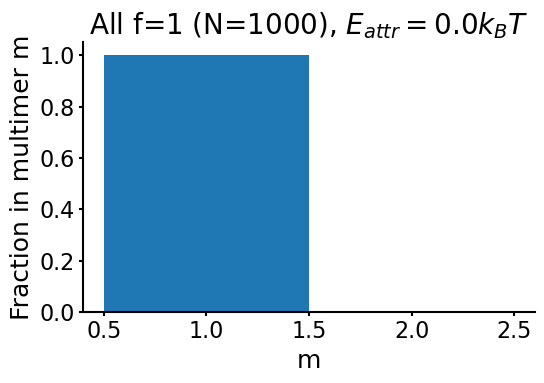

In [29]:
plot_cluster_size_distribution(0.0, 1)

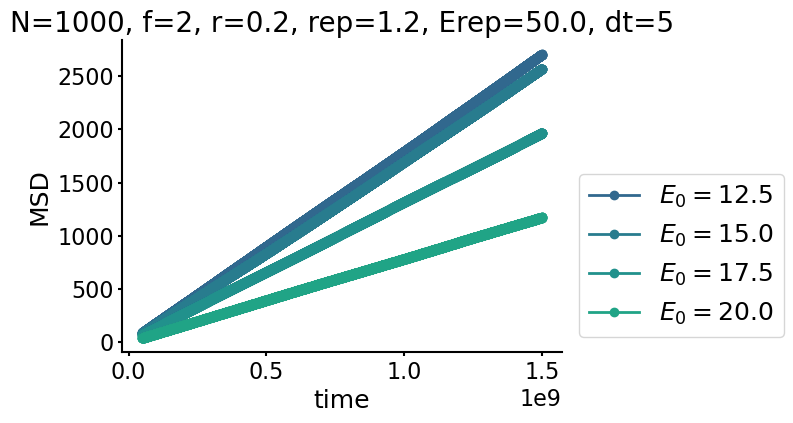

In [18]:
Dapps_f2, alphas_f2 = plot_time_ave_msd_dt(2)

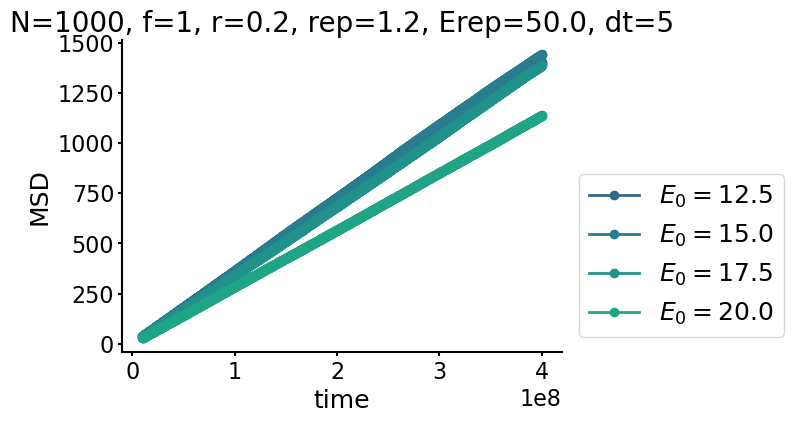

In [19]:
Dapps_f1, alphas_f1 = plot_time_ave_msd_dt(1)

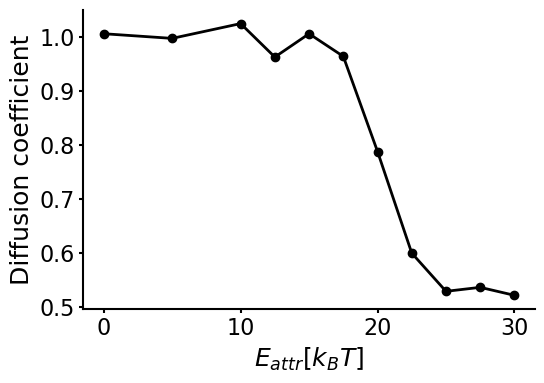

In [24]:
fig, ax = plt.subplots()
colors = ['black', 'red']
E0s = [float(str(path.name).split('_')[2][2:]) for path in simdir.glob(f"N1000_f1*_v0.3_r0.2_rep1.2_Erep50.0_dt5")]
E0s = np.sort(E0s)
D1 = np.mean(Dapps_f1[0:5])
D_monomer = 1.0
meanD_vs_E0 = []
for E0 in E0s:
    histogram = np.load(simdir/f'N1000_f1_E0{E0}_v0.3_r0.2_rep1.2_Erep50.0_dt5/cluster_size_histogram.npy')
    weights = histogram / histogram.sum()
    num_clusters = (weights * 1000) / np.arange(1, len(weights) + 1)
    #diffusion coefficient distribution based on cluster sizes
    diffusion_clusters = (D_monomer / np.arange(1, len(weights) + 1))
    mean_diffusion = (diffusion_clusters @ num_clusters) / 1000
    meanD_vs_E0.append(mean_diffusion)
meanD_vs_E0 = np.array(meanD_vs_E0)
#ax.plot(E0s, (meanD_vs_E0 / meanD_vs_E0[0])*Dapps_f1[0], 'k--', label='f=1')
ax.plot(E0s, Dapps_f1/D1, 'k-o', label='f=1 (all)')
E0s = [float(str(path.name).split('_')[2][2:]) for path in simdir.glob(f"N1000_f2*_v0.3_r0.2_rep1.2_Erep50.0_dt5")]
E0s = np.sort(E0s)
meanD_vs_E0 = []
for E0 in E0s:
    histogram = np.load(simdir/f'N1000_f2_E0{E0}_v0.3_r0.2_rep1.2_Erep50.0_dt5/cluster_size_histogram.npy')
    weights = histogram / histogram.sum()
    num_clusters = (weights * 1000) / np.arange(1, len(weights) + 1)
    #diffusion coefficient distribution based on cluster sizes
    diffusion_clusters = (D_monomer / np.arange(1, len(weights) + 1))
    mean_diffusion = (diffusion_clusters @ num_clusters) / 1000
    meanD_vs_E0.append(mean_diffusion)
meanD_vs_E0 = np.array(meanD_vs_E0)
#ax.plot(E0s, (meanD_vs_E0 / meanD_vs_E0[0])*Dapps_f2[0], 'r--', label='f=2')
#ax.plot(E0s, Dapps_f2, 'r-o', label='f=2 (all)')
#ax.legend()
ax.set_xlabel('$E_{attr} [k_B T]$')
ax.set_ylabel('Diffusion coefficient')
#ax.set_title("Predicted (--) vs Measured(-)")
fig.tight_layout()
plt.savefig('plots/SF_diff_vs_Eattr_f1.pdf', transparent=True)